In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = "/content/drive/My Drive/Assignment_1"

In [5]:
classes = ['YesSunglasses','NoSunglasses']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

YesSunglasses: 311 Images
NoSunglasses: 313 Images


In [8]:
round(len(images)*0.8)

250

In [9]:
train_dir = "/content/drive/My Drive/Assignment_1/train"
val_dir = "/content/drive/My Drive/Assignment_1/val"

In [10]:
BATCH_SIZE = 100
IMG_SHAPE = 150 

In [11]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.10,
                    height_shift_range=.10,
                    horizontal_flip=True,
                    zoom_range=0.3
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 499 images belonging to 2 classes.


In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

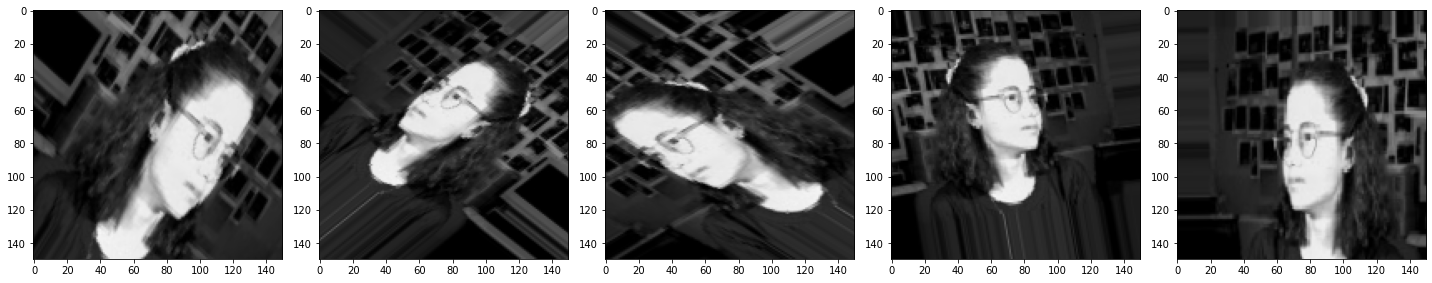

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 125 images belonging to 2 classes.


In [16]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(2))

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [20]:
epochs = 80

In [21]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)
model.save_weights("weights.h5")

Epoch 1/80
5/5 [==============================] - 99s 20s/step - loss: 0.8509 - accuracy: 0.5090 - val_loss: 0.6944 - val_accuracy: 0.5040
Epoch 2/80
5/5 [==============================] - 4s 744ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6935 - val_accuracy: 0.5040
Epoch 3/80
5/5 [==============================] - 4s 715ms/step - loss: 0.6920 - accuracy: 0.5471 - val_loss: 0.6947 - val_accuracy: 0.4960
Epoch 4/80
5/5 [==============================] - 4s 728ms/step - loss: 0.6924 - accuracy: 0.4990 - val_loss: 0.6961 - val_accuracy: 0.4960
Epoch 5/80
5/5 [==============================] - 4s 734ms/step - loss: 0.6881 - accuracy: 0.5110 - val_loss: 0.6926 - val_accuracy: 0.4640
Epoch 6/80
5/5 [==============================] - 4s 722ms/step - loss: 0.6754 - accuracy: 0.5611 - val_loss: 0.6937 - val_accuracy: 0.4560
Epoch 7/80
5/5 [==============================] - 4s 730ms/step - loss: 0.6340 - accuracy: 0.6934 - val_loss: 0.6380 - val_accuracy: 0.6880
Epoch 8/80
5/5 [=====

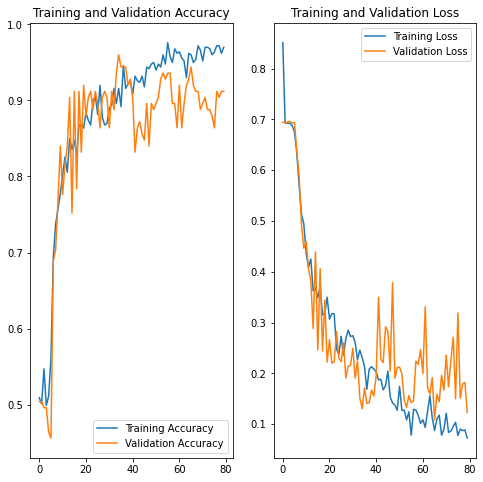

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()